In [37]:
import pandas as pd
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import scipy.stats as stats
import numpy as np
import locale
from matplotlib.ticker import FuncFormatter

# Configurando o locale para usar vírgula como separador decimal
locale.setlocale(locale.LC_NUMERIC, 'pt_BR.UTF-8')

# Formatador personalizado para usar vírgula no eixo y
def comma_formatter(x, pos):
    return locale.format_string('%.2f', x).replace('.', ',')

## Análise estatística de latência das queries comparando 3 métodos.

# Conversão de duração
def convert_duration_to_ms(duration_str):
    """
    Converte a string de duração para milissegundos.
    """
    duration_str = duration_str.replace('Âµ', 'µ')
    
    if duration_str.endswith('ms'):
        return float(duration_str.replace('ms', ''))
    elif duration_str.endswith('s') and not duration_str.endswith('µs'):
        return float(duration_str.replace('s', '')) * 1000
    elif duration_str.endswith('µs'):
        return float(duration_str.replace('µs', '')) / 1000
    else:
        raise ValueError(f"Formato de duração não reconhecido: {duration_str}")

# Processamento de logs
def parse_dns_logs_from_file(filename):
    """
    Processa um arquivo de log DNS e retorna um DataFrame.
    """
    try:
        with open(filename, 'r') as file:
            log_content = file.read()
        
        records = []
        pattern = r'(\d{4}/\d{2}/\d{2} \d{2}:\d{2}:\d{2}) worker:\[(\d+)\] reqid:\[(\d+)\] qname:\[([^\]]+)\] qtype:\[([^\]]+)\] respid:\[([^\]]+)\] rcode:\[([^\]]+)\] respflags:\[([^\]]+)\] err:\[([^\]]*)\] duration:\[([^\]]+)\]'
        
        linhas_com_erro = 0
        total_linhas = 0
        
        for line in log_content.strip().split('\n'):
            total_linhas += 1
            match = re.match(pattern, line)
            if match:
                timestamp, worker, reqid, qname, qtype, respid, rcode, respflags, err, duration = match.groups()
                
                try:
                    duration = convert_duration_to_ms(duration)
                    timestamp = datetime.strptime(timestamp, '%Y/%m/%d %H:%M:%S')
                    
                    respid = None if respid == '<nil>' else int(respid)
                    rcode = None if rcode == '<nil>' else rcode
                    respflags = None if respflags == '<nil>' else respflags
                    err = None if err == '<nil>' else err
                    
                    record = {
                        'timestamp': timestamp,
                        'worker': int(worker),
                        'reqid': int(reqid),
                        'qname': qname,
                        'qtype': qtype,
                        'respid': respid,
                        'rcode': rcode,
                        'respflags': respflags,
                        'err': err,
                        'duration': duration
                    }
                    records.append(record)
                except ValueError as e:
                    print(f"Aviso: Erro ao processar valores da linha: {line}")
                    print(f"Erro específico: {str(e)}")
                    linhas_com_erro += 1
                    continue
            else:
                print(f"Aviso: Não foi possível fazer o parse da linha: {line}")
                linhas_com_erro += 1
        
        df = pd.DataFrame(records)
        
        print(f"\nResumo do processamento do arquivo {filename}:")
        print(f"Total de linhas processadas: {total_linhas}")
        print(f"Linhas processadas com sucesso: {len(records)}")
        print(f"Linhas com erro: {linhas_com_erro}")
        
        df['duration_unit'] = 'ms'
        
        return df
    
    except FileNotFoundError:
        print(f"Erro: O arquivo '{filename}' não foi encontrado.")
        return None
    except Exception as e:
        print(f"Erro ao processar o arquivo: {str(e)}")
        return None

def show_cleaning_stats(df_original, df_cleaned, name):
    removed = len(df_original) - len(df_cleaned)
    print(f"\nEstatísticas de limpeza - {name}:")
    print(f"Registros originais: {len(df_original)}")
    print(f"Registros após limpeza: {len(df_cleaned)}")
    print(f"Registros removidos: {removed} ({locale.format_string('%.2f', removed/len(df_original)*100)}%)")

# Função para calcular intervalo de confiança
def calculate_confidence_interval(data, confidence=0.99):
    n = len(data)
    mean = np.mean(data)
    se = stats.sem(data)
    ci = stats.t.interval(confidence, n-1, mean, se)
    return mean, ci[0], ci[1]

# Formatando números com vírgula como separador decimal
def format_decimal(value, precision=4):
    return locale.format_string(f'%.{precision}f', value)

# Carregando os dados
file1 = '../../Python/results_20241221/requests_l_dnsfw_rpz.log'
file2 = '../../Python/results_20241221/requests_l_dnsfw_xdp.log'
file3 = '../../Python/results_20241221/requests_l_dnsfw_no.log'

print("Processando arquivo DNSFW RPZ:")
df_rpz = parse_dns_logs_from_file(file1)
print("\nProcessando arquivo DNSFW XDP:")
df_xdp = parse_dns_logs_from_file(file2)
print("\nProcessando arquivo Sem DNSFW:")
df_no = parse_dns_logs_from_file(file3)

# Limpando erros UDP
df_rpz_clean = df_rpz[~df_rpz['err'].str.contains('read udp|write udp|dial udp', na=False, regex=True)]
df_xdp_clean = df_xdp[~df_xdp['err'].str.contains('read udp|write udp|dial udp', na=False, regex=True)]
df_no_clean = df_no[~df_no['err'].str.contains('read udp|write udp|dial udp', na=False, regex=True)]

show_cleaning_stats(df_rpz, df_rpz_clean, "DNSFW RPZ")
show_cleaning_stats(df_xdp, df_xdp_clean, "DNSFW XDP")
show_cleaning_stats(df_no, df_no_clean, "Sem DNSFW")

Processando arquivo DNSFW RPZ:

Resumo do processamento do arquivo ../../Python/results_20241221/requests_l_dnsfw_rpz.log:
Total de linhas processadas: 1000
Linhas processadas com sucesso: 1000
Linhas com erro: 0

Processando arquivo DNSFW XDP:

Resumo do processamento do arquivo ../../Python/results_20241221/requests_l_dnsfw_xdp.log:
Total de linhas processadas: 1000
Linhas processadas com sucesso: 1000
Linhas com erro: 0

Processando arquivo Sem DNSFW:

Resumo do processamento do arquivo ../../Python/results_20241221/requests_l_dnsfw_no.log:
Total de linhas processadas: 1000
Linhas processadas com sucesso: 1000
Linhas com erro: 0

Estatísticas de limpeza - DNSFW RPZ:
Registros originais: 1000
Registros após limpeza: 1000
Registros removidos: 0 (0,00%)

Estatísticas de limpeza - DNSFW XDP:
Registros originais: 1000
Registros após limpeza: 1000
Registros removidos: 0 (0,00%)

Estatísticas de limpeza - Sem DNSFW:
Registros originais: 1000
Registros após limpeza: 1000
Registros removidos

In [39]:
# Análise Estatística Básica
# Estatísticas descritivas
stats_comparison = pd.DataFrame({
    'DNSFW RPZ': df_rpz_clean['duration'].describe(),
    'DNSFW XDP': df_xdp_clean['duration'].describe(),
    'Sem DNSFW': df_no_clean['duration'].describe()
})

# Formatando os valores com vírgula
stats_formatted = stats_comparison.copy()
for col in stats_formatted.columns:
    stats_formatted[col] = stats_formatted[col].apply(lambda x: format_decimal(x))

print("\nEstatísticas comparativas de duração (ms):")
print(stats_formatted)

# Métricas de Desempenho
# Calculando métricas e intervalos de confiança
metrics_rpz = calculate_confidence_interval(df_rpz_clean['duration'])
metrics_xdp = calculate_confidence_interval(df_xdp_clean['duration'])
metrics_no = calculate_confidence_interval(df_no_clean['duration'])



Estatísticas comparativas de duração (ms):
       DNSFW RPZ  DNSFW XDP  Sem DNSFW
count  1000,0000  1000,0000  1000,0000
mean      1,0006     0,9985     0,9859
std       0,1803     0,2071     0,1775
min       0,4933     0,3955     0,4916
25%       0,8774     0,8635     0,8677
50%       0,9828     0,9740     0,9772
75%       1,0996     1,0960     1,0906
max       1,7332     1,8314     1,9970


In [41]:
performance_metrics = pd.DataFrame({
    'Métrica': ['Média (ms)', 'Mediana (ms)', 'Desvio Padrão (ms)', 
                'IC Inferior (ms)', 'IC Superior (ms)'],
    'DNSFW RPZ': [
        df_rpz_clean['duration'].mean(),
        df_rpz_clean['duration'].median(),
        df_rpz_clean['duration'].std(),
        metrics_rpz[1],
        metrics_rpz[2]
    ],
    'DNSFW XDP': [
        df_xdp_clean['duration'].mean(),
        df_xdp_clean['duration'].median(),
        df_xdp_clean['duration'].std(),
        metrics_xdp[1],
        metrics_xdp[2]
    ],
    'Sem DNSFW': [
        df_no_clean['duration'].mean(),
        df_no_clean['duration'].median(),
        df_no_clean['duration'].std(),
        metrics_no[1],
        metrics_no[2]
    ]
})

# Formatando os valores com vírgula
performance_metrics_formatted = performance_metrics.copy()
for col in performance_metrics.columns:
    if col != 'Métrica':
        performance_metrics_formatted[col] = performance_metrics[col].apply(lambda x: format_decimal(x))

print("\nMétricas de Desempenho:")
print(performance_metrics_formatted)


Métricas de Desempenho:
              Métrica DNSFW RPZ DNSFW XDP Sem DNSFW
0          Média (ms)    1,0006    0,9985    0,9859
1        Mediana (ms)    0,9828    0,9740    0,9772
2  Desvio Padrão (ms)    0,1803    0,2071    0,1775
3    IC Inferior (ms)    0,9859    0,9816    0,9714
4    IC Superior (ms)    1,0154    1,0154    1,0004


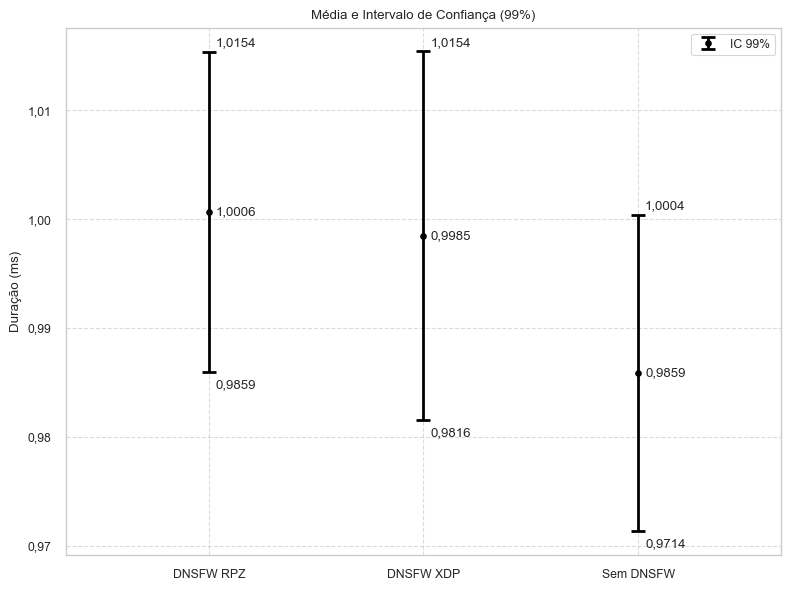

In [43]:
# Configurando dados para o gráfico
models = ['DNSFW RPZ', 'DNSFW XDP', 'Sem DNSFW']
means = [metrics_rpz[0], metrics_xdp[0], metrics_no[0]]
ci_lower = [metrics_rpz[1], metrics_xdp[1], metrics_no[1]]
ci_upper = [metrics_rpz[2], metrics_xdp[2], metrics_no[2]]

# Configuração do gráfico
plt.figure(figsize=(8, 6))
plt.style.use('seaborn-v0_8-paper')
sns.set_context("paper")
sns.set_style("whitegrid")

# Ajustando posições no eixo x para ficarem mais centralizadas
x_pos = [0.2, 0.5, 0.8]  # Ajustado para 3 posições

# Calculando as barras de erro como a diferença absoluta entre a média e os limites
yerr = np.vstack([np.abs(np.array(ci_lower) - np.array(means)), 
                  np.abs(np.array(ci_upper) - np.array(means))])

# Aplica o formatador para usar vírgula no eixo Y
formatter = FuncFormatter(comma_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.errorbar(x_pos, means, 
            yerr=yerr,
            fmt='o', color='black', capsize=5, capthick=2, elinewidth=2, label='IC 99%')

# Configurando limites do eixo x para centralizar
plt.xlim(0, 1)

# Adicionando anotações para cada ponto
for i, (mean, lower, upper) in enumerate(zip(means, ci_lower, ci_upper)):
    # Formatando os valores com vírgula como separador decimal
    mean_text = format_decimal(mean)
    ci_lower_text = format_decimal(lower)
    ci_upper_text = format_decimal(upper)
    
    # Calculando posições para as anotações
    y_offset = (upper - lower) * 0.1  # 10% do intervalo de confiança
    
    # Adicionando as anotações
    plt.annotate(mean_text.replace('.', ','), 
                xy=(x_pos[i], mean), 
                xytext=(5, 0), 
                textcoords='offset points',
                va='center')
    
    plt.annotate(ci_lower_text.replace('.', ','), 
                xy=(x_pos[i], lower), 
                xytext=(5, -5), 
                textcoords='offset points',
                va='top')
    
    plt.annotate(ci_upper_text.replace('.', ','), 
                xy=(x_pos[i], upper), 
                xytext=(5, 2), 
                textcoords='offset points',
                va='bottom')

# Configurações do gráfico
plt.title('Média e Intervalo de Confiança (99%)')
plt.ylabel('Duração (ms)')
plt.xticks(x_pos, models)
plt.grid(True, linestyle='--', alpha=0.7)

plt.legend()
plt.tight_layout()
plt.savefig('latencia_comparativa.png',
            dpi=300,
            bbox_inches='tight',
            pad_inches=0.1,
            format='png',
            transparent=False,
            facecolor='white',
            edgecolor='none')
plt.show()

In [45]:
# Análise estatística comparativa
print("\nMétricas de Desempenho e Intervalos de Confiança (99%):")
print(performance_metrics_formatted)

# Diferenças entre os métodos
diff_rpz_xdp = df_xdp_clean['duration'].mean() - df_rpz_clean['duration'].mean()
diff_rpz_no = df_no_clean['duration'].mean() - df_rpz_clean['duration'].mean()
diff_xdp_no = df_no_clean['duration'].mean() - df_xdp_clean['duration'].mean()

diff_rpz_xdp_median = df_xdp_clean['duration'].median() - df_rpz_clean['duration'].median()
diff_rpz_no_median = df_no_clean['duration'].median() - df_rpz_clean['duration'].median()
diff_xdp_no_median = df_no_clean['duration'].median() - df_xdp_clean['duration'].median()

print("\nDiferenças entre os métodos:")
print(f"Diferença das médias (XDP - RPZ): {format_decimal(diff_rpz_xdp).replace('.', ',')} ms")
print(f"Diferença das médias (Sem DNSFW - RPZ): {format_decimal(diff_rpz_no).replace('.', ',')} ms")
print(f"Diferença das médias (Sem DNSFW - XDP): {format_decimal(diff_xdp_no).replace('.', ',')} ms")

print(f"Diferença das medianas (XDP - RPZ): {format_decimal(diff_rpz_xdp_median).replace('.', ',')} ms")
print(f"Diferença das medianas (Sem DNSFW - RPZ): {format_decimal(diff_rpz_no_median).replace('.', ',')} ms")
print(f"Diferença das medianas (Sem DNSFW - XDP): {format_decimal(diff_xdp_no_median).replace('.', ',')} ms")

# Testes estatísticos para comparar os métodos
t_stat_rpz_xdp, p_value_rpz_xdp = stats.ttest_ind(df_rpz_clean['duration'], df_xdp_clean['duration'])
t_stat_rpz_no, p_value_rpz_no = stats.ttest_ind(df_rpz_clean['duration'], df_no_clean['duration'])
t_stat_xdp_no, p_value_xdp_no = stats.ttest_ind(df_xdp_clean['duration'], df_no_clean['duration'])

print("\nResultados dos Testes Estatísticos:")
print("RPZ vs XDP:")
print(f"Estatística t: {format_decimal(t_stat_rpz_xdp).replace('.', ',')}")
print(f"Valor p: {format_decimal(p_value_rpz_xdp).replace('.', ',')}")
if p_value_rpz_xdp < 0.05:
    print("Há diferença estatisticamente significativa entre RPZ e XDP (p < 0,05)")
else:
    print("Não há diferença estatisticamente significativa entre RPZ e XDP (p >= 0,05)")

print("\nRPZ vs Sem DNSFW:")
print(f"Estatística t: {format_decimal(t_stat_rpz_no).replace('.', ',')}")
print(f"Valor p: {format_decimal(p_value_rpz_no).replace('.', ',')}")
if p_value_rpz_no < 0.05:
    print("Há diferença estatisticamente significativa entre RPZ e Sem DNSFW (p < 0,05)")
else:
    print("Não há diferença estatisticamente significativa entre RPZ e Sem DNSFW (p >= 0,05)")

print("\nXDP vs Sem DNSFW:")
print(f"Estatística t: {format_decimal(t_stat_xdp_no).replace('.', ',')}")
print(f"Valor p: {format_decimal(p_value_xdp_no).replace('.', ',')}")
if p_value_xdp_no < 0.05:
    print("Há diferença estatisticamente significativa entre XDP e Sem DNSFW (p < 0,05)")
else:
    print("Não há diferença estatisticamente significativa entre XDP e Sem DNSFW (p >= 0,05)")

# Calculando as diferenças percentuais médias
diff_percent_rpz_xdp = ((df_rpz_clean['duration'].mean() - df_xdp_clean['duration'].mean()) / df_rpz_clean['duration'].mean()) * 100
diff_percent_rpz_no = ((df_rpz_clean['duration'].mean() - df_no_clean['duration'].mean()) / df_rpz_clean['duration'].mean()) * 100
diff_percent_xdp_no = ((df_xdp_clean['duration'].mean() - df_no_clean['duration'].mean()) / df_xdp_clean['duration'].mean()) * 100

print("\nDiferenças percentuais médias:")
print(f"RPZ vs XDP: {format_decimal(diff_percent_rpz_xdp, 2).replace('.', ',')}%")
print(f"RPZ vs Sem DNSFW: {format_decimal(diff_percent_rpz_no, 2).replace('.', ',')}%")
print(f"XDP vs Sem DNSFW: {format_decimal(diff_percent_xdp_no, 2).replace('.', ',')}%")


Métricas de Desempenho e Intervalos de Confiança (99%):
              Métrica DNSFW RPZ DNSFW XDP Sem DNSFW
0          Média (ms)    1,0006    0,9985    0,9859
1        Mediana (ms)    0,9828    0,9740    0,9772
2  Desvio Padrão (ms)    0,1803    0,2071    0,1775
3    IC Inferior (ms)    0,9859    0,9816    0,9714
4    IC Superior (ms)    1,0154    1,0154    1,0004

Diferenças entre os métodos:
Diferença das médias (XDP - RPZ): -0,0022 ms
Diferença das médias (Sem DNSFW - RPZ): -0,0148 ms
Diferença das médias (Sem DNSFW - XDP): -0,0126 ms
Diferença das medianas (XDP - RPZ): -0,0087 ms
Diferença das medianas (Sem DNSFW - RPZ): -0,0056 ms
Diferença das medianas (Sem DNSFW - XDP): 0,0032 ms

Resultados dos Testes Estatísticos:
RPZ vs XDP:
Estatística t: 0,2498
Valor p: 0,8028
Não há diferença estatisticamente significativa entre RPZ e XDP (p >= 0,05)

RPZ vs Sem DNSFW:
Estatística t: 1,8469
Valor p: 0,0649
Não há diferença estatisticamente significativa entre RPZ e Sem DNSFW (p >= 0,05)


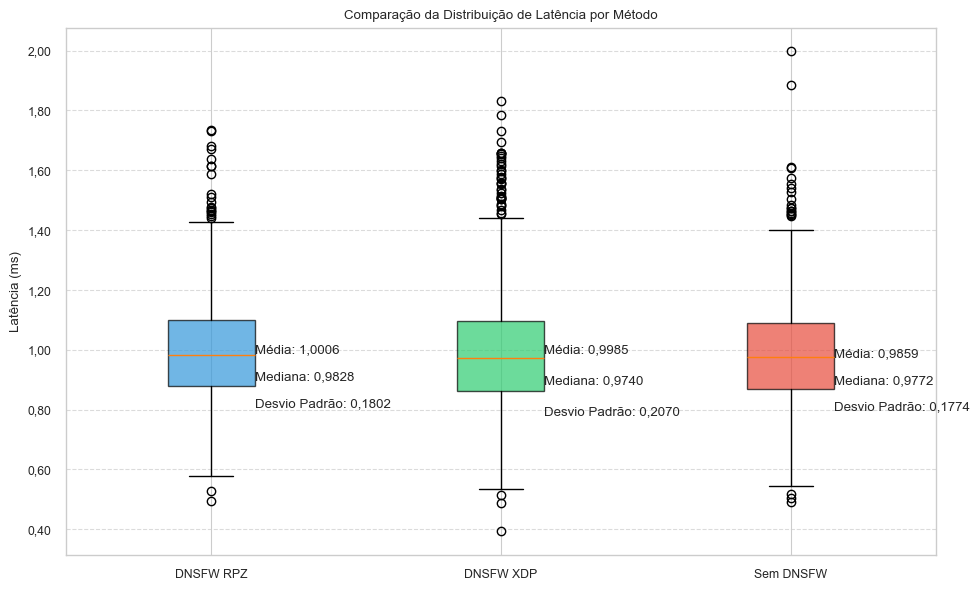

In [51]:
# Função para formatar strings com vírgula como separador decimal
def format_decimal(value, precision=4):
    return locale.format_string(f'%.{precision}f', value).replace('.', ',')

# 1. Gráfico de boxplot para comparação de distribuição
plt.figure(figsize=(10, 6))
data_to_plot = [df_rpz_clean['duration'], df_xdp_clean['duration'], df_no_clean['duration']]
labels = ['DNSFW RPZ', 'DNSFW XDP', 'Sem DNSFW']

bp = plt.boxplot(data_to_plot, tick_labels=labels, patch_artist=True)

# Customize as cores dos boxplots
colors = ['#3498db', '#2ecc71', '#e74c3c']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Adiciona estatísticas como anotações
for i, (data, label) in enumerate(zip(data_to_plot, labels)):
    mean_val = np.mean(data)
    median_val = np.median(data)
    std_val = np.std(data)
    
    # Posição x para as anotações (ligeiramente à direita do boxplot)
    x_pos = i + 1.15
    
    # Altura das anotações (usando a média como referência)
    mean_height = mean_val
    
    # Texto formatado com vírgula
    mean_text = f"Média: {format_decimal(mean_val)}"
    median_text = f"Mediana: {format_decimal(median_val)}"
    std_text = f"Desvio Padrão: {format_decimal(std_val)}"
    
    # Adiciona os textos como anotações
    plt.annotate(mean_text, xy=(x_pos, mean_height), ha='left', va='center')
    plt.annotate(median_text, xy=(x_pos, mean_height - std_val/2), ha='left', va='center')
    plt.annotate(std_text, xy=(x_pos, mean_height - std_val), ha='left', va='center')

# Aplica o formatador para usar vírgula no eixo Y
formatter = FuncFormatter(comma_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.title('Comparação da Distribuição de Latência por Método')
plt.ylabel('Latência (ms)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('boxplot_comparativo.png', dpi=300, bbox_inches='tight')
plt.show()


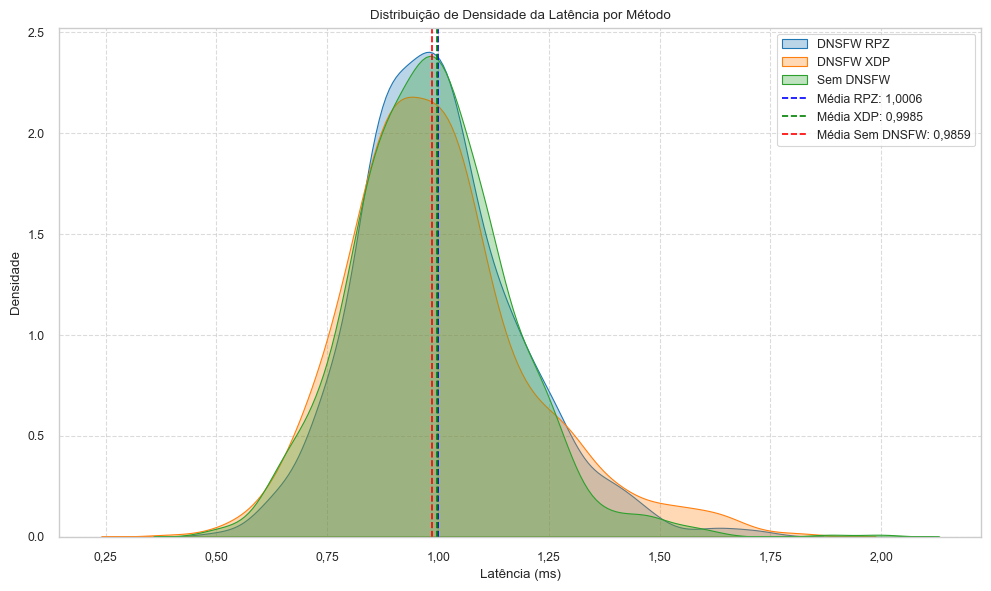

In [53]:
# 2. Gráfico de densidade para visualizar as distribuições
plt.figure(figsize=(10, 6))
sns.kdeplot(df_rpz_clean['duration'], label='DNSFW RPZ', fill=True, alpha=0.3)
sns.kdeplot(df_xdp_clean['duration'], label='DNSFW XDP', fill=True, alpha=0.3)
sns.kdeplot(df_no_clean['duration'], label='Sem DNSFW', fill=True, alpha=0.3)

# Adicionar linhas verticais para as médias
plt.axvline(df_rpz_clean['duration'].mean(), color='blue', linestyle='--', 
           label=f'Média RPZ: {format_decimal(df_rpz_clean["duration"].mean())}')
plt.axvline(df_xdp_clean['duration'].mean(), color='green', linestyle='--', 
           label=f'Média XDP: {format_decimal(df_xdp_clean["duration"].mean())}')
plt.axvline(df_no_clean['duration'].mean(), color='red', linestyle='--', 
           label=f'Média Sem DNSFW: {format_decimal(df_no_clean["duration"].mean())}')

# Aplica o formatador para usar vírgula no eixo X
formatter = FuncFormatter(comma_formatter)
plt.gca().xaxis.set_major_formatter(formatter)

plt.title('Distribuição de Densidade da Latência por Método')
plt.xlabel('Latência (ms)')
plt.ylabel('Densidade')
plt.legend()
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('densidade_comparativa.png', dpi=300, bbox_inches='tight')
plt.show()

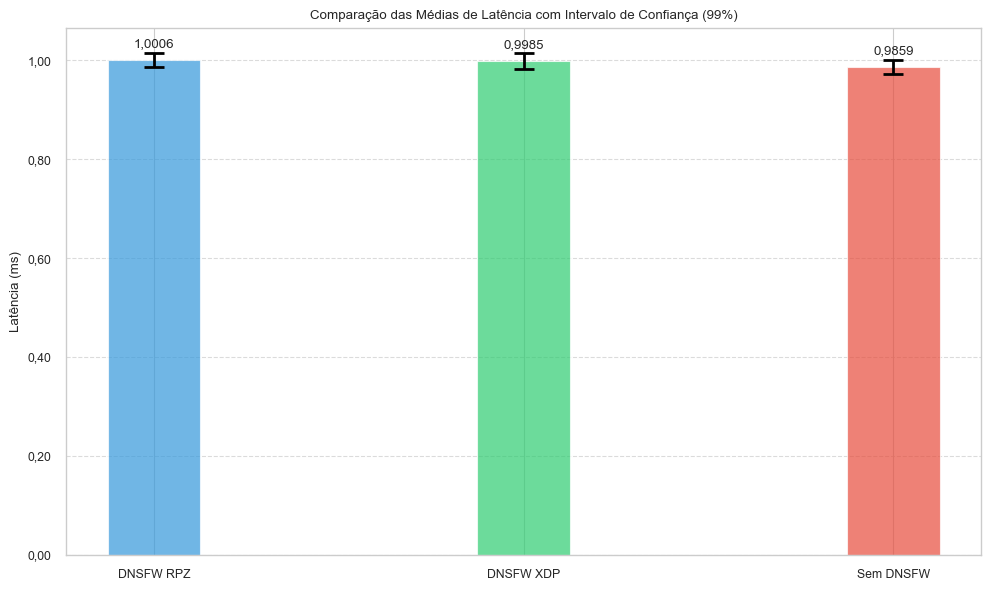

In [55]:
# 3. Gráfico de barras para comparação direta das médias com intervalo de confiança
# Calculando os intervalos de confiança
def calculate_confidence_interval(data, confidence=0.99):
    n = len(data)
    mean = np.mean(data)
    se = stats.sem(data)
    ci = stats.t.interval(confidence, n-1, mean, se)
    return mean, ci[0], ci[1]

metrics_rpz = calculate_confidence_interval(df_rpz_clean['duration'])
metrics_xdp = calculate_confidence_interval(df_xdp_clean['duration'])
metrics_no = calculate_confidence_interval(df_no_clean['duration'])

# Configura as barras
plt.figure(figsize=(10, 6))
bar_width = 0.25
index = np.arange(3)

means = [metrics_rpz[0], metrics_xdp[0], metrics_no[0]]
error = [
    [metrics_rpz[0] - metrics_rpz[1], metrics_xdp[0] - metrics_xdp[1], metrics_no[0] - metrics_no[1]],  # erro inferior
    [metrics_rpz[2] - metrics_rpz[0], metrics_xdp[2] - metrics_xdp[0], metrics_no[2] - metrics_no[0]]   # erro superior
]

bars = plt.bar(index, means, bar_width, 
              alpha=0.7, 
              color=['#3498db', '#2ecc71', '#e74c3c'],
              yerr=error, 
              capsize=7,
              error_kw={'elinewidth': 2, 'capthick': 2})

# Adiciona valores formatados com vírgula nas barras
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            format_decimal(height), 
            ha='center', va='bottom', rotation=0)

# Aplica o formatador para usar vírgula no eixo Y
formatter = FuncFormatter(comma_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.title('Comparação das Médias de Latência com Intervalo de Confiança (99%)')
plt.ylabel('Latência (ms)')
plt.xticks(index, ['DNSFW RPZ', 'DNSFW XDP', 'Sem DNSFW'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('barras_comparativas.png', dpi=300, bbox_inches='tight')
plt.show()

In [57]:
# 4. Tabela comparativa detalhada
comparison_data = {
    'Métrica': ['Média (ms)', 'Mediana (ms)', 'Desvio Padrão (ms)', 'IC Inferior (ms)', 'IC Superior (ms)', 'Mínimo (ms)', 'Máximo (ms)'],
    'DNSFW RPZ': [metrics_rpz[0], df_rpz_clean['duration'].median(), df_rpz_clean['duration'].std(), metrics_rpz[1], metrics_rpz[2], df_rpz_clean['duration'].min(), df_rpz_clean['duration'].max()],
    'DNSFW XDP': [metrics_xdp[0], df_xdp_clean['duration'].median(), df_xdp_clean['duration'].std(), metrics_xdp[1], metrics_xdp[2], df_xdp_clean['duration'].min(), df_xdp_clean['duration'].max()],
    'Sem DNSFW': [metrics_no[0], df_no_clean['duration'].median(), df_no_clean['duration'].std(), metrics_no[1], metrics_no[2], df_no_clean['duration'].min(), df_no_clean['duration'].max()]
}

# Cria tabela de comparação
comparison_df = pd.DataFrame(comparison_data)

# Formata os valores com vírgula
formatted_df = comparison_df.copy()
for col in formatted_df.columns:
    if col != 'Métrica':
        formatted_df[col] = formatted_df[col].apply(lambda x: format_decimal(x))

print("\nTabela Comparativa Detalhada:")
print(formatted_df.to_string(index=False))

# Salva a tabela como CSV com formatação adequada
formatted_df.to_csv('tabela_comparativa.csv', index=False, sep=';', decimal=',')

# 5. Matriz de comparação estatística (p-values)
methods = ['RPZ', 'XDP', 'Sem DNSFW']
datasets = [df_rpz_clean['duration'], df_xdp_clean['duration'], df_no_clean['duration']]
p_values = np.zeros((3, 3))

for i in range(3):
    for j in range(3):
        if i != j:
            _, p_val = stats.ttest_ind(datasets[i], datasets[j])
            p_values[i, j] = p_val
        else:
            p_values[i, j] = 1.0  # Diagonal principal (comparação do método consigo mesmo)

print("\nMatriz de Valores-p (Teste t):")
p_values_df = pd.DataFrame(p_values, index=methods, columns=methods)
for i in range(3):
    for j in range(3):
        p_values_df.iloc[i, j] = format_decimal(p_values_df.iloc[i, j]).replace('.', ',')
print(p_values_df)

# 6. Diferenças percentuais entre os métodos
print("\nDiferenças Percentuais entre os Métodos:")
diff_rpz_xdp = ((metrics_rpz[0] - metrics_xdp[0]) / metrics_rpz[0]) * 100
diff_rpz_no = ((metrics_rpz[0] - metrics_no[0]) / metrics_rpz[0]) * 100
diff_xdp_no = ((metrics_xdp[0] - metrics_no[0]) / metrics_xdp[0]) * 100

print(f"RPZ vs XDP: {format_decimal(diff_rpz_xdp, 2)}%")
print(f"RPZ vs Sem DNSFW: {format_decimal(diff_rpz_no, 2)}%")
print(f"XDP vs Sem DNSFW: {format_decimal(diff_xdp_no, 2)}%")


Tabela Comparativa Detalhada:
           Métrica DNSFW RPZ DNSFW XDP Sem DNSFW
        Média (ms)    1,0006    0,9985    0,9859
      Mediana (ms)    0,9828    0,9740    0,9772
Desvio Padrão (ms)    0,1803    0,2071    0,1775
  IC Inferior (ms)    0,9859    0,9816    0,9714
  IC Superior (ms)    1,0154    1,0154    1,0004
       Mínimo (ms)    0,4933    0,3955    0,4916
       Máximo (ms)    1,7332    1,8314    1,9970

Matriz de Valores-p (Teste t):
              RPZ     XDP Sem DNSFW
RPZ        1,0000  0,8028    0,0649
XDP        0,8028  1,0000    0,1440
Sem DNSFW  0,0649  0,1440    1,0000

Diferenças Percentuais entre os Métodos:
RPZ vs XDP: 0,22%
RPZ vs Sem DNSFW: 1,48%
XDP vs Sem DNSFW: 1,26%


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1556\2983292973.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1,0000' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  p_values_df.iloc[i, j] = format_decimal(p_values_df.iloc[i, j]).replace('.', ',')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1556\2983292973.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0,8028' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  p_values_df.iloc[i, j] = format_decimal(p_values_df.iloc[i, j]).replace('.', ',')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1556\2983292973.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0,0649' has dtype incompatible with float64, pl